# Tree Methods

Aim: Predict housing prices using a regression model.

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [49]:
def get_data(url: str) -> pd.DataFrame:
    df = pd.read_csv(url)
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    TODO:
    - choose cols: the cols in the instructions are the only cols in the dataset so no need to choose
    - fill nas with 0
    - log transform median house value
    - train-test-val split
    - dictvectorizer
    """
    # only one column has null values so this is fine
    df = df.fillna(0)
    df.median_house_value = np.log1p(df.median_house_value)
    return df

def train_test_val_split(df: pd.DataFrame) -> pd.DataFrame:
    train_df, combined_test_df = train_test_split(df, test_size=0.4, random_state=1)
    test_df, val_df = train_test_split(combined_test_df, test_size=0.5, random_state=1)
    return train_df, test_df, val_df

def prep_training_data(train_df: pd.DataFrame, test_df: pd.DataFrame, val_df: pd.DataFrame) -> pd.DataFrame:
    y_train = train_df.median_house_value
    y_test = test_df.median_house_value
    y_val = val_df.median_house_value

    # drop median house value from train_df
    train_df.drop('median_house_value', axis=1, inplace=True)
    test_df.drop('median_house_value', axis=1, inplace=True)
    val_df.drop('median_house_value', axis=1, inplace=True)

    return train_df, test_df, val_df, y_train, y_test, y_val

def one_hot_transform(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    One hot encodes the specified columns in the dataframe.

    Args:
        df (pd.DataFrame): dataframe to one hot encode
        cols (list[str]): list of columns to one hot encode

    Returns:
        pd.DataFrame: dataframe with specified columns one hot encoded
    """
    for col in cols:
        onehot = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
        onehot_encoded = onehot.fit_transform(df[col].values.reshape(-1, 1))
        df = pd.concat([df, onehot_encoded], axis=1).drop(f'{col}', axis=1)
    
    return df


In [52]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

df = clean_data(get_data(url))

df = one_hot_transform(df, ['ocean_proximity'])

train_df, test_df, val_df = train_test_val_split(df)


train_df, test_df, val_df, y_train, y_test, y_val = prep_training_data(train_df, test_df, val_df)

In [61]:
clf = tree.DecisionTreeRegressor(max_depth=1)
clf = clf.fit(train_df, y_train)
y_preds = clf.predict(test_df)


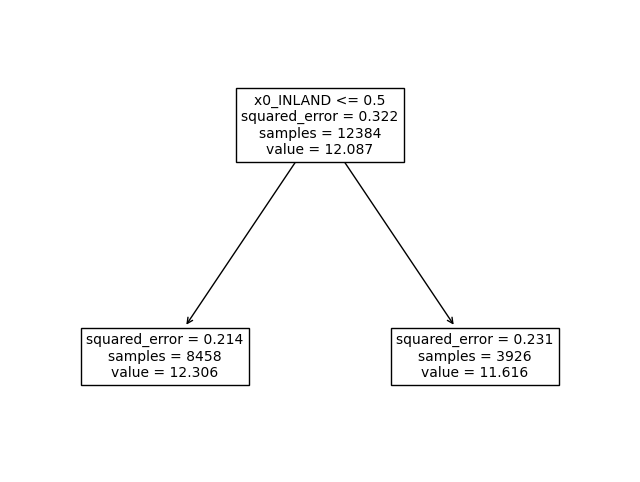

In [62]:
_, ax = plt.subplots(figsize=(8, 6))
_ = plot_tree(clf, ax=ax, feature_names=train_df.columns, fontsize=10)

In [65]:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rfr = rfr.fit(train_df, y_train)
y_preds = rfr.predict(test_df)


In [68]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
print(f'RMSE: {rmse}')

RMSE: 0.24945577690249893


In [70]:
def random_forest_regressor(train_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Trains a random forest regressor on the training data and prints the RMSE on the test data.

    Args:
        train_df (pd.DataFrame): training data
        test_df (pd.DataFrame): test data
        y_train (pd.DataFrame): training labels
        y_test (pd.DataFrame): test labels
    """
    max_depth = [10, 15, 20, 25]

    for i in max_depth:
        rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1, max_depth=i)
        rfr = rfr.fit(train_df, y_train)
        y_preds = rfr.predict(test_df)
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        print(f'RMSE: {rmse}')
    

    # n_estimators = list(range(10, 201, 10))
    # for i in n_estimators:
    #     rfr = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=1)
    #     rfr = rfr.fit(train_df, y_train)
    #     y_preds = rfr.predict(test_df)
    #     rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    #     print(f'RMSE: {rmse}')

random_forest_regressor(train_df, test_df, y_train, y_test)

RMSE: 0.2584129317977883
RMSE: 0.24940402451392435
RMSE: 0.2500409275224987
RMSE: 0.25008289179037685


In [72]:
def random_forest_regressor(train_df: pd.DataFrame, test_df: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame) -> None:
    """
    Trains a random forest regressor on the training data and prints the RMSE on the test data.

    Args:
        train_df (pd.DataFrame): training data
        test_df (pd.DataFrame): test data
        y_train (pd.DataFrame): training labels
        y_test (pd.DataFrame): test labels
    """

    rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1, max_depth=20)
    rfr = rfr.fit(train_df, y_train)
    y_preds = rfr.predict(test_df)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE: {rmse}')
    return rfr
    

    # n_estimators = list(range(10, 201, 10))
    # for i in n_estimators:
    #     rfr = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=1)
    #     rfr = rfr.fit(train_df, y_train)
    #     y_preds = rfr.predict(test_df)
    #     rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    #     print(f'RMSE: {rmse}')

rfr = random_forest_regressor(train_df, test_df, y_train, y_test)

RMSE: 0.2500409275224987


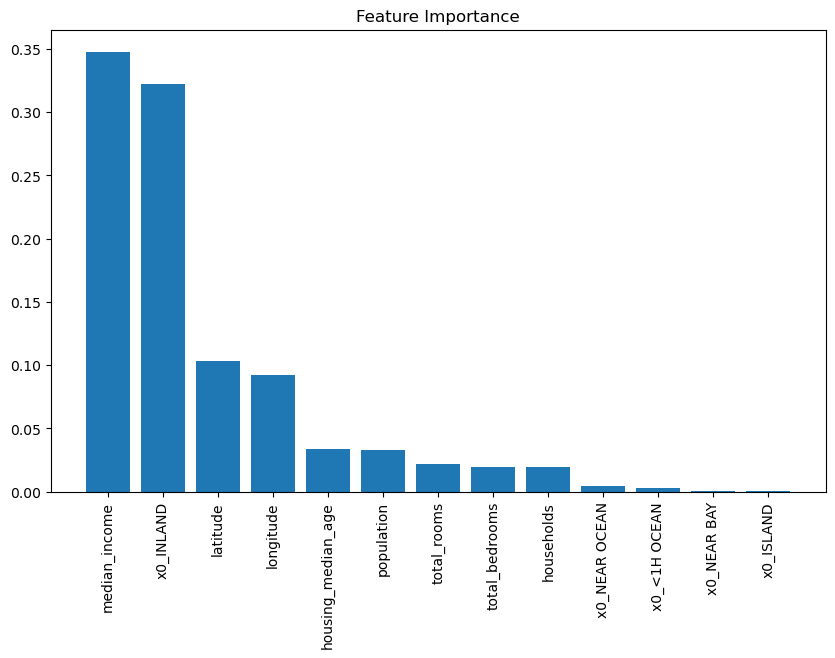

In [74]:
rfr.feature_importances_

def plot_feature_importances(rfr: RandomForestRegressor, train_df: pd.DataFrame) -> None:
    """
    Plots the feature importances of a random forest regressor.

    Args:
        rfr (RandomForestRegressor): random forest regressor
        train_df (pd.DataFrame): training data
    """
    importances = rfr.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [train_df.columns[i] for i in indices]
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(train_df
        .shape[1]), importances[indices])
    plt.xticks(range(train_df.shape[1]), names, rotation=90)
    plt.show()

plot_feature_importances(rfr, train_df)
